In [1]:
import pandas as pd
import sqlite3

# Load Datasets
commitments = pd.read_csv("Financial Commitments.csv")
allocations = pd.read_csv("Financial Allocations.csv")

# Normalize the database: Remove redundant data
commitments = commitments[['Country', 'EU member', 'GDP in 2021($ billion)',
                           'Financial commitments($ billion)',
                           'Humanitarian commitments($ billion)',
                           'Military commitments($ billion)']]

allocations = allocations[['Country', 'Financial allocations($ billion)',
                           'Humanitarian allocations($ billion)',
                           'Military allocations($ billion)']]

# Save to SQLite Database
conn = sqlite3.connect("ukraine_aid.db")
commitments.to_sql("commitments", conn, if_exists="replace", index=False)
allocations.to_sql("allocations", conn, if_exists="replace", index=False)

# SQL Join to fetch merged data
query = """
SELECT 
    c.Country, 
    c."GDP in 2021($ billion)", 
    c."Financial commitments($ billion)", 
    c."Humanitarian commitments($ billion)", 
    c."Military commitments($ billion)",
    a."Financial allocations($ billion)", 
    a."Humanitarian allocations($ billion)", 
    a."Military allocations($ billion)"
FROM commitments c
JOIN allocations a ON c.Country = a.Country
"""

# Execute query and load into DataFrame
df = pd.read_sql(query, conn)
conn.close()

# Print merged data
print("Merged Data:")
print(df)


Merged Data:
           Country  GDP in 2021($ billion)  Financial commitments($ billion)  \
0        Australia             1552.667363                          0.000000   
1          Austria              480.368404                          0.728552   
2          Belgium              594.104177                          0.491301   
3         Bulgaria               84.056313                          0.000000   
4           Canada             1988.336332                          4.887591   
5          Croatia               68.955083                          0.000000   
6           Cyprus               28.407868                          0.001071   
7   Czech Republic              281.777887                          0.000000   
8          Denmark              398.303273                          0.137112   
9          Estonia               37.191166                          0.000000   
10         Finland              297.301883                          0.099426   
11          France         

Missing Values:
 Country                                0
GDP in 2021($ billion)                 0
Financial commitments($ billion)       0
Humanitarian commitments($ billion)    0
Military commitments($ billion)        0
Financial allocations($ billion)       1
Humanitarian allocations($ billion)    1
Military allocations($ billion)        1
dtype: int64


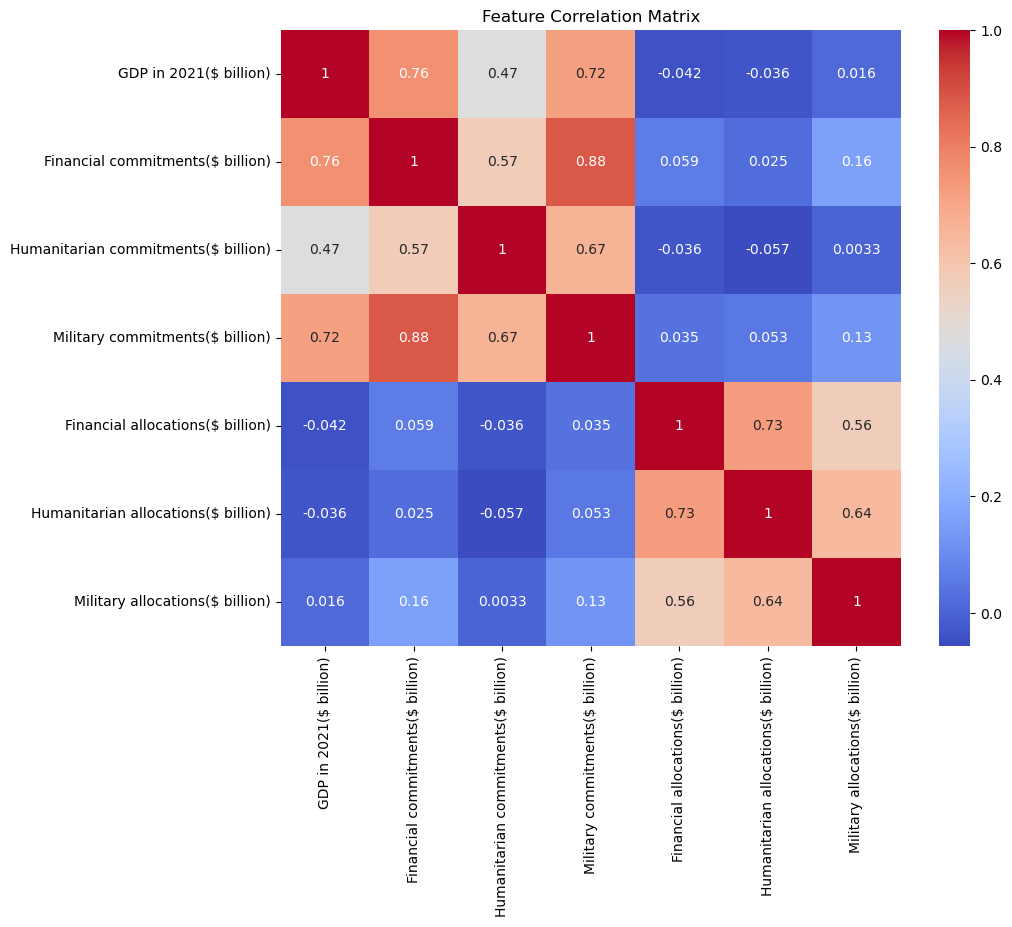

Data Split Completed.
Training Data Shape: (32, 3), Testing Data Shape: (9, 3)


In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split

# Check for missing values and fill them with 0
print("Missing Values:\n", df.isnull().sum())
df = df.fillna(0)

# Correlation Matrix (using only numeric columns)
numeric_columns = df.select_dtypes(include=['float64', 'int64']).columns
plt.figure(figsize=(10, 8))
sns.heatmap(df[numeric_columns].corr(), annot=True, cmap="coolwarm")
plt.title("Feature Correlation Matrix")
plt.show()

# Target Variable: Define Reliability
df['Total_Commitments'] = (df['Financial commitments($ billion)'] + 
                           df['Humanitarian commitments($ billion)'] + 
                           df['Military commitments($ billion)'])
df['Total_Allocations'] = (df['Financial allocations($ billion)'] + 
                           df['Humanitarian allocations($ billion)'] + 
                           df['Military allocations($ billion)'])
df['Reliability'] = (df['Total_Allocations'] / df['Total_Commitments']).apply(lambda x: 1 if x >= 0.8 else 0)

# Select features and target variable
X = df[['GDP in 2021($ billion)', 'Total_Commitments', 'Total_Allocations']]
y = df['Reliability']

# Split Data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print("Data Split Completed.")
print(f"Training Data Shape: {X_train.shape}, Testing Data Shape: {X_test.shape}")


In [5]:
from sklearn.pipeline import Pipeline
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, confusion_matrix


print("Experiment 1: Logistic Regression")
pipeline_lr = Pipeline([
    ('scaler', StandardScaler()),
    ('model', LogisticRegression())
])

pipeline_lr.fit(X_train, y_train)
y_pred_lr = pipeline_lr.predict(X_test)

f1_lr = f1_score(y_test, y_pred_lr)
conf_matrix_lr = confusion_matrix(y_test, y_pred_lr)

print("F1 Score:", f1_lr)
print("Confusion Matrix:\n", conf_matrix_lr)

Experiment 1: Logistic Regression
F1 Score: 0.6666666666666666
Confusion Matrix:
 [[3 3]
 [0 3]]


In [7]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score


print("\nExperiment 2: Multiple Models Comparison")
models = {
    "Logistic Regression": LogisticRegression(),
    "Random Forest": RandomForestClassifier()
}

results = {}
for name, model in models.items():
    pipeline = Pipeline([
        ('scaler', StandardScaler()),
        ('model', model)
    ])
    pipeline.fit(X_train, y_train)
    y_pred = pipeline.predict(X_test)
    f1 = f1_score(y_test, y_pred)
    results[name] = f1
    print(f"{name} F1 Score: {f1}")



Experiment 2: Multiple Models Comparison
Logistic Regression F1 Score: 0.6666666666666666
Random Forest F1 Score: 0.75


In [9]:
from sklearn.feature_selection import VarianceThreshold
print("\nExperiment 3: Feature Selection with Variance Threshold")
selector = VarianceThreshold(threshold=0.1)
X_selected = selector.fit_transform(X_train)
print("Features retained after Variance Threshold:", X_selected.shape)


Experiment 3: Feature Selection with Variance Threshold
Features retained after Variance Threshold: (32, 3)


In [11]:
from sklearn.decomposition import PCA
print("\nExperiment 4: PCA for Dimensionality Reduction")
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_train)
print("Explained Variance Ratio:", pca.explained_variance_ratio_)


Experiment 4: PCA for Dimensionality Reduction
Explained Variance Ratio: [9.99989353e-01 7.60123676e-06]


In [13]:
import joblib

# Assuming 'model' is your trained model
joblib.dump(model, 'reliability_model.pkl')


['reliability_model.pkl']